✓ All directories created successfully
🚀 ADVANCED STOCK PRICE PREDICTION SYSTEM

📊 AVAILABLE STOCKS:
   AAPL     - Apple Inc.
   TSLA     - Tesla Inc.
   GOOGL    - Alphabet Inc. (Google)
   MSFT     - Microsoft Corporation
   AMZN     - Amazon.com Inc.
   META     - Meta Platforms Inc.
   NVDA     - NVIDIA Corporation
   NFLX     - Netflix Inc.
   BTC-USD  - Bitcoin USD
   ETH-USD  - Ethereum USD
   SPY      - SPDR S&P 500 ETF
   QQQ      - Invesco QQQ Trust
   JPM      - JPMorgan Chase & Co.
   JNJ      - Johnson & Johnson
   V        - Visa Inc.
   PG       - Procter & Gamble Co.
   DIS      - Walt Disney Co.
   NKE      - Nike Inc.
   BA       - Boeing Co.
   XOM      - Exxon Mobil Corp.
   KO       - Coca-Cola Co.

------------------------------------------------------------
❌ No matches found for 'SFX'. Using AAPL as default.

✅ Selected: AAPL - Apple Inc.

📥 Downloading stock data...
✅ Downloaded 1255 trading days of data
📅 Date range: 2020-10-21 to 2025-10-20
💾 Raw data saved: 

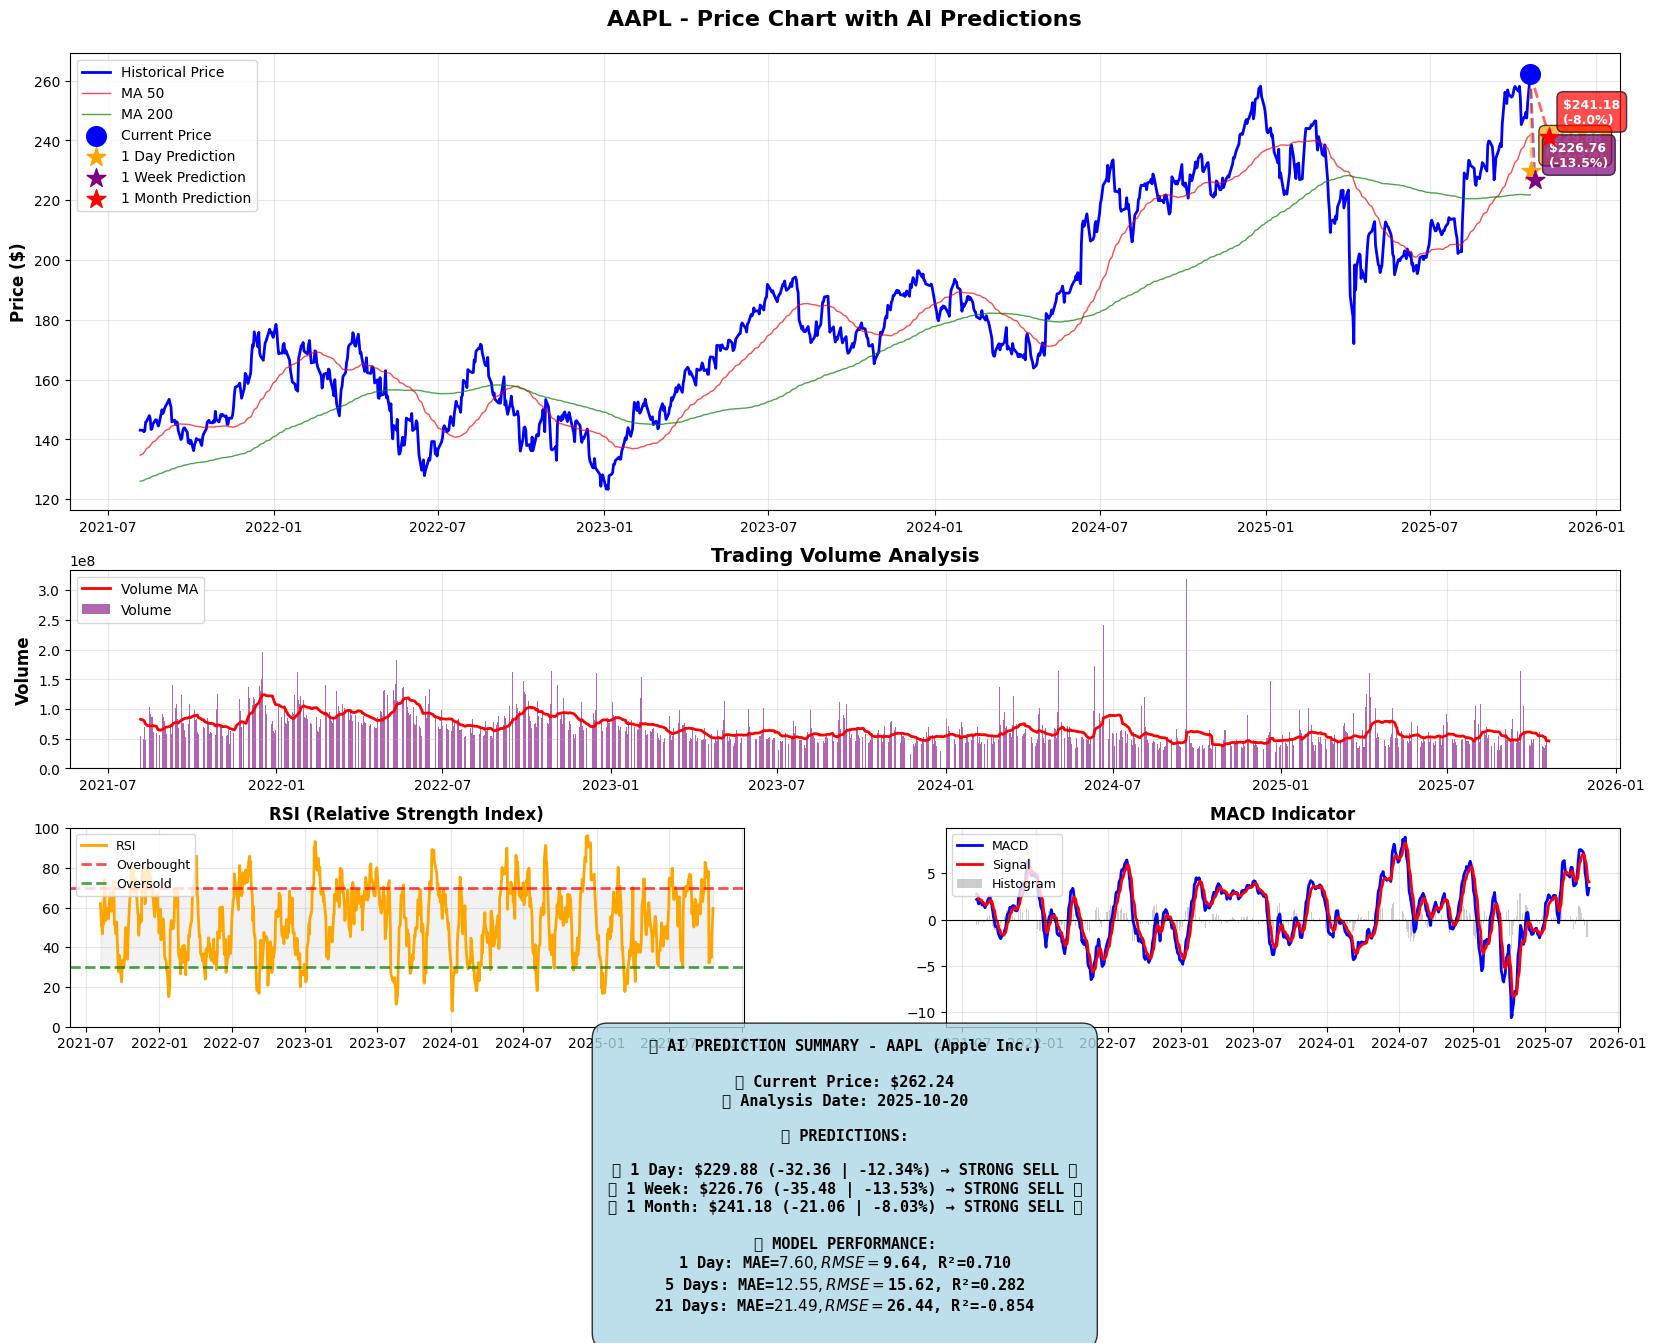

✅ Advanced visualizations with predictions generated!

💾 SAVING MODELS
✅ Model saved: Training/models/AAPL_predictor.pkl
✅ Main model saved: Training/models/main.pkl
✅ Metadata saved: Training/models/AAPL_metadata.pkl

✅ ANALYSIS COMPLETE
✓ Stock: AAPL - Apple Inc.
✓ Data: 1255 trading days analyzed
✓ Predictions: 3 time horizons
✓ Visualizations: Advanced charts with predictions
✓ Models: Saved as AAPL_predictor.pkl and main.pkl
✓ Files: All data saved in Training/ directory

🎯 QUICK RELOAD INSTRUCTIONS:
   To use the trained model later:
   ```
   import joblib
   model = joblib.load('Training/models/main.pkl')
   # or
   model = joblib.load('Training/models/AAPL_predictor.pkl')
   ```

📂 Generated Files:
   📊 Charts:
      - Training/charts/AAPL_complete_analysis.png
      - Training/charts/AAPL_interactive_predictions.html
   💾 Data:
      - Training/stock_data/AAPL_raw_data.csv
   🤖 Models:
      - Training/models/AAPL_predictor.pkl
      - Training/models/AAPL_metadata.pkl
      

In [ ]:
#-------------------[IMPORT MODULES]-----------------------#
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import os
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

#-------------------[STOCK DATABASE]-----------------------#
STOCK_DATABASE = {
    'AAPL': 'Apple Inc.',
    'TSLA': 'Tesla Inc.',
    'GOOGL': 'Alphabet Inc. (Google)',
    'MSFT': 'Microsoft Corporation',
    'AMZN': 'Amazon.com Inc.',
    'META': 'Meta Platforms Inc.',
    'NVDA': 'NVIDIA Corporation',
    'NFLX': 'Netflix Inc.',
    'BTC-USD': 'Bitcoin USD',
    'ETH-USD': 'Ethereum USD',
    'SPY': 'SPDR S&P 500 ETF',
    'QQQ': 'Invesco QQQ Trust',
    'JPM': 'JPMorgan Chase & Co.',
    'JNJ': 'Johnson & Johnson',
    'V': 'Visa Inc.',
    'PG': 'Procter & Gamble Co.',
    'DIS': 'Walt Disney Co.',
    'NKE': 'Nike Inc.',
    'BA': 'Boeing Co.',
    'XOM': 'Exxon Mobil Corp.',
    'KO': 'Coca-Cola Co.'
}

#-------------------[TECHNICAL INDICATORS FUNCTIONS]-----------------------#
def calculate_technical_indicators(data):
    """Calculate technical indicators for visualization"""
    df = data.copy()
    
    # Flatten MultiIndex columns if present
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    # Ensure we're working with Series
    close = df['Close'].squeeze()
    volume = df['Volume'].squeeze()
    
    # Moving Averages
    df['MA_7'] = close.rolling(7).mean()
    df['MA_20'] = close.rolling(20).mean()
    df['MA_50'] = close.rolling(50).mean()
    df['MA_200'] = close.rolling(200).mean()
    
    # Exponential Moving Averages
    df['EMA_12'] = close.ewm(span=12, adjust=False).mean()
    df['EMA_26'] = close.ewm(span=26, adjust=False).mean()
    
    # MACD
    ema_12 = close.ewm(span=12, adjust=False).mean()
    ema_26 = close.ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']
    
    # RSI
    delta = close.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    bb_middle = close.rolling(20).mean()
    bb_std = close.rolling(20).std()
    df['BB_Middle'] = bb_middle
    df['BB_Upper'] = bb_middle + (bb_std * 2)
    df['BB_Lower'] = bb_middle - (bb_std * 2)
    
    # Volume indicators
    df['Volume_MA'] = volume.rolling(20).mean()
    
    return df

#-------------------[STOCK PREDICTION CLASS]-----------------------#
class StockPricePredictor:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.feature_columns = None
        self.is_trained = False
        self.ticker = None
        self.company_name = None
        self.training_metrics = {}
    
    def prepare_features(self, data):
        """Enhanced feature engineering for model training"""
        df = data.copy()
        
        # Flatten MultiIndex columns if present
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
            
        # Ensure we're working with Series
        close = df['Close'].squeeze()
        open_price = df['Open'].squeeze()
        high = df['High'].squeeze()
        low = df['Low'].squeeze()
        volume = df['Volume'].squeeze()
        
        # Price-based features
        df['Price_Range'] = high - low
        df['Price_Change'] = close - open_price
        df['Close_Open_Ratio'] = close / open_price
        df['High_Low_Ratio'] = high / low
        
        # Moving Averages
        for window in [5, 7, 10, 20, 50, 200]:
            ma = close.rolling(window).mean()
            df[f'MA_{window}'] = ma
            df[f'Price_vs_MA_{window}'] = close / ma
        
        # Exponential Moving Averages
        ema_12 = close.ewm(span=12, adjust=False).mean()
        ema_26 = close.ewm(span=26, adjust=False).mean()
        df['EMA_12'] = ema_12
        df['EMA_26'] = ema_26
        
        # MACD
        macd = ema_12 - ema_26
        df['MACD'] = macd
        df['MACD_Signal'] = macd.ewm(span=9, adjust=False).mean()
        df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']
        
        # RSI
        delta = close.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))
        
        # Bollinger Bands
        bb_middle = close.rolling(20).mean()
        bb_std = close.rolling(20).std()
        df['BB_Middle'] = bb_middle
        df['BB_Upper'] = bb_middle + (bb_std * 2)
        df['BB_Lower'] = bb_middle - (bb_std * 2)
        df['BB_Position'] = (close - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
        
        # Volume indicators
        volume_ma = volume.rolling(20).mean()
        df['Volume_MA'] = volume_ma
        df['Volume_Ratio'] = volume / volume_ma
        
        # Momentum indicators
        for period in [5, 10, 20]:
            df[f'Momentum_{period}'] = close - close.shift(period)
            df[f'ROC_{period}'] = ((close - close.shift(period)) / close.shift(period)) * 100
        
        # Volatility
        df['Volatility_20'] = close.rolling(20).std()
        
        # Daily returns
        df['Daily_Return'] = close.pct_change()
        
        # Lag features
        for lag in [1, 2, 3]:
            df[f'Close_Lag_{lag}'] = close.shift(lag)
            df[f'Volume_Lag_{lag}'] = volume.shift(lag)
        
        # Target variables for different time horizons
        df['Target_1_Day'] = close.shift(-1)
        df['Target_5_Days'] = close.shift(-5)
        df['Target_21_Days'] = close.shift(-21)
        
        return df
    
    def train_model(self, data, target_horizon='1_Day'):
        """Train the prediction model"""
        print(f"🔄 Training model for {target_horizon.replace('_', ' ')} prediction...")
        
        # Prepare features
        data_with_features = self.prepare_features(data)
        data_clean = data_with_features.dropna()
        
        # Define feature columns
        feature_candidates = [
            'Open', 'High', 'Low', 'Close', 'Volume',
            'Price_Range', 'Price_Change', 'Close_Open_Ratio', 'High_Low_Ratio',
            'MA_5', 'MA_20', 'MA_50', 'MA_200',
            'Price_vs_MA_5', 'Price_vs_MA_50', 'Price_vs_MA_200',
            'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Histogram',
            'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Position',
            'Volume_Ratio', 'Momentum_5', 'ROC_5',
            'Volatility_20', 'Daily_Return',
            'Close_Lag_1', 'Close_Lag_2', 'Volume_Lag_1'
        ]
        
        # Only use available features
        available_features = [col for col in feature_candidates if col in data_clean.columns]
        target_column = f'Target_{target_horizon}'
        
        if target_column not in data_clean.columns:
            print(f"❌ Target column {target_column} not found!")
            return False
        
        X = data_clean[available_features]
        y = data_clean[target_column]
        
        # Split data chronologically
        split_index = int(len(X) * 0.8)
        X_train, X_test = X[:split_index], X[split_index:]
        y_train, y_test = y[:split_index], y[split_index:]
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Train model
        self.model = RandomForestRegressor(
            n_estimators=100,
            max_depth=15,
            random_state=42,
            n_jobs=-1
        )
        
        self.model.fit(X_train_scaled, y_train)
        
        # Evaluate model
        y_pred = self.model.predict(X_test_scaled)
        
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        # Store metrics
        self.training_metrics[target_horizon] = {
            'mae': mae,
            'rmse': rmse,
            'r2_score': r2,
            'test_predictions': y_pred,
            'test_actual': y_test.values
        }
        
        print(f"📈 Model Performance ({target_horizon.replace('_', ' ')}):")
        print(f"   MAE: ${mae:.2f} | RMSE: ${rmse:.2f} | R² Score: {r2:.4f}")
        
        self.is_trained = True
        self.feature_columns = available_features
        
        return True
    
    def predict_future(self, data):
        """Predict future stock prices"""
        if not self.is_trained:
            print("❌ Model not trained! Please train the model first.")
            return None
        
        # Prepare the latest data for prediction
        data_with_features = self.prepare_features(data)
        
        # Get the last row with valid feature values
        latest_data = data_with_features[self.feature_columns].iloc[-1:].values
        
        # Scale features
        latest_data_scaled = self.scaler.transform(latest_data)
        
        # Make prediction
        predicted_price = self.model.predict(latest_data_scaled)[0]
        
        # Get current price
        if isinstance(data['Close'], pd.DataFrame):
            current_price = data['Close'].iloc[-1].values[0]
        else:
            current_price = data['Close'].iloc[-1]
        
        return {
            'current_price': current_price,
            'predicted_price': predicted_price,
            'price_change': predicted_price - current_price,
            'price_change_pct': ((predicted_price / current_price) - 1) * 100
        }

#-------------------[FIND STOCK]-----------------------#
def find_stock(search_term):
    """Find stock in database"""
    matches = {}
    
    for symbol, name in STOCK_DATABASE.items():
        if (search_term.upper() in symbol.upper() or 
            search_term.lower() in name.lower()):
            matches[symbol] = name
    
    return matches

#-------------------[CREATE DIRECTORIES]-----------------------#
def create_directories():
    """Create necessary directories"""
    directories = ['Training/stock_data', 'Training/models', 'Training/charts']
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
    print("✓ All directories created successfully")

#-------------------[VISUALIZE WITH PREDICTIONS]-----------------------#
def visualize_with_predictions(data, ticker, company_name, predictions, predictor):
    """Create comprehensive visualizations with prediction results"""
    print("\n📊 Generating advanced visualizations with predictions...")
    
    # Calculate technical indicators
    data_with_indicators = calculate_technical_indicators(data)
    data_clean = data_with_indicators.dropna()
    
    # Get current price
    if isinstance(data['Close'], pd.DataFrame):
        current_price = data['Close'].iloc[-1].values[0]
    else:
        current_price = data['Close'].iloc[-1]
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(5, 2, hspace=0.3, wspace=0.3)
    
    # 1. Main Price Chart with Predictions
    ax1 = fig.add_subplot(gs[0:2, :])
    ax1.plot(data_clean.index, data_clean['Close'], label='Historical Price', color='blue', linewidth=2)
    ax1.plot(data_clean.index, data_clean['MA_50'], label='MA 50', color='red', linewidth=1, alpha=0.7)
    ax1.plot(data_clean.index, data_clean['MA_200'], label='MA 200', color='green', linewidth=1, alpha=0.7)
    
    # Add prediction markers
    last_date = data_clean.index[-1]
    ax1.scatter(last_date, current_price, color='blue', s=200, zorder=5, marker='o', label='Current Price')
    
    colors = {'1 Day': 'orange', '1 Week': 'purple', '1 Month': 'red'}
    offsets = {'1 Day': 1, '1 Week': 5, '1 Month': 21}
    
    for horizon, pred in predictions.items():
        future_date = last_date + timedelta(days=offsets[horizon])
        ax1.scatter(future_date, pred['predicted_price'], color=colors[horizon], 
                   s=200, zorder=5, marker='*', label=f'{horizon} Prediction')
        ax1.plot([last_date, future_date], [current_price, pred['predicted_price']], 
                color=colors[horizon], linestyle='--', linewidth=2, alpha=0.6)
        
        # Add annotation
        ax1.annotate(f"${pred['predicted_price']:.2f}\n({pred['price_change_pct']:+.1f}%)",
                    xy=(future_date, pred['predicted_price']),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.5', fc=colors[horizon], alpha=0.7),
                    fontsize=9, fontweight='bold', color='white')
    
    ax1.set_title(f'{ticker} - Price Chart with AI Predictions', fontsize=16, fontweight='bold', pad=20)
    ax1.legend(loc='upper left', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylabel('Price ($)', fontsize=12, fontweight='bold')
    
    # 2. Volume Chart
    ax2 = fig.add_subplot(gs[2, :])
    ax2.bar(data_clean.index, data_clean['Volume'], color='purple', alpha=0.6, label='Volume')
    ax2.plot(data_clean.index, data_clean['Volume_MA'], color='red', linewidth=2, label='Volume MA')
    ax2.set_title('Trading Volume Analysis', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylabel('Volume', fontsize=12, fontweight='bold')
    
    # 3. RSI Indicator
    ax3 = fig.add_subplot(gs[3, 0])
    ax3.plot(data_clean.index, data_clean['RSI'], color='orange', linewidth=2, label='RSI')
    ax3.axhline(70, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Overbought')
    ax3.axhline(30, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Oversold')
    ax3.fill_between(data_clean.index, 30, 70, alpha=0.1, color='gray')
    ax3.set_title('RSI (Relative Strength Index)', fontsize=12, fontweight='bold')
    ax3.set_ylim(0, 100)
    ax3.legend(loc='upper left', fontsize=9)
    ax3.grid(True, alpha=0.3)
    
    # 4. MACD Indicator
    ax4 = fig.add_subplot(gs[3, 1])
    ax4.plot(data_clean.index, data_clean['MACD'], color='blue', linewidth=2, label='MACD')
    ax4.plot(data_clean.index, data_clean['MACD_Signal'], color='red', linewidth=2, label='Signal')
    ax4.bar(data_clean.index, data_clean['MACD_Histogram'], color='gray', alpha=0.4, label='Histogram')
    ax4.axhline(0, color='black', linestyle='-', linewidth=0.8)
    ax4.set_title('MACD Indicator', fontsize=12, fontweight='bold')
    ax4.legend(loc='upper left', fontsize=9)
    ax4.grid(True, alpha=0.3)
    
    # 5. Prediction Summary Box
    ax5 = fig.add_subplot(gs[4, :])
    ax5.axis('off')
    
    # Create prediction summary text
    summary_text = f"🤖 AI PREDICTION SUMMARY - {ticker} ({company_name})\n\n"
    summary_text += f"💰 Current Price: ${current_price:.2f}\n"
    summary_text += f"📅 Analysis Date: {last_date.strftime('%Y-%m-%d')}\n\n"
    
    summary_text += "📈 PREDICTIONS:\n"
    for horizon, pred in predictions.items():
        change_emoji = "🚀" if pred['price_change_pct'] > 0 else "📉"
        summary_text += f"\n{change_emoji} {horizon}: ${pred['predicted_price']:.2f} "
        summary_text += f"({pred['price_change']:+.2f} | {pred['price_change_pct']:+.2f}%)"
        
        if pred['price_change_pct'] > 5:
            summary_text += " → STRONG BUY 🚀"
        elif pred['price_change_pct'] > 2:
            summary_text += " → BUY 📈"
        elif pred['price_change_pct'] > -2:
            summary_text += " → HOLD ⚖️"
        elif pred['price_change_pct'] > -5:
            summary_text += " → SELL 📉"
        else:
            summary_text += " → STRONG SELL 🔻"
    
    # Add model performance
    summary_text += "\n\n📊 MODEL PERFORMANCE:\n"
    for horizon, metrics in predictor.training_metrics.items():
        summary_text += f"{horizon.replace('_', ' ')}: MAE=${metrics['mae']:.2f}, "
        summary_text += f"RMSE=${metrics['rmse']:.2f}, R²={metrics['r2_score']:.3f}\n"
    
    ax5.text(0.5, 0.5, summary_text, transform=ax5.transAxes,
            fontsize=11, verticalalignment='center', horizontalalignment='center',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8, pad=1),
            fontfamily='monospace', fontweight='bold')
    
    plt.savefig(f'Training/charts/{ticker}_complete_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Interactive Plotly Chart with Predictions
    plot_data = data_clean.reset_index()
    
    fig2 = go.Figure()
    
    # Candlestick
    fig2.add_trace(go.Candlestick(
        x=plot_data['Date'],
        open=plot_data['Open'],
        high=plot_data['High'],
        low=plot_data['Low'],
        close=plot_data['Close'],
        name='Price'
    ))
    
    # Moving averages
    fig2.add_trace(go.Scatter(x=plot_data['Date'], y=plot_data['MA_50'],
                             name='MA 50', line=dict(color='red', width=1)))
    fig2.add_trace(go.Scatter(x=plot_data['Date'], y=plot_data['MA_200'],
                             name='MA 200', line=dict(color='green', width=1)))
    
    # Add prediction points
    for horizon, pred in predictions.items():
        future_date = last_date + timedelta(days=offsets[horizon])
        fig2.add_trace(go.Scatter(
            x=[future_date],
            y=[pred['predicted_price']],
            mode='markers+text',
            name=f'{horizon} Prediction',
            marker=dict(size=15, symbol='star', color=colors[horizon]),
            text=[f"${pred['predicted_price']:.2f}"],
            textposition="top center"
        ))
    
    fig2.update_layout(
        title=f'{ticker} - {company_name} - Interactive Chart with Predictions',
        xaxis_title='Date',
        yaxis_title='Price ($)',
        xaxis_rangeslider_visible=False,
        height=700,
        template='plotly_white'
    )
    
    fig2.write_html(f'Training/charts/{ticker}_interactive_predictions.html')
    fig2.show()
    
    print("✅ Advanced visualizations with predictions generated!")

#-------------------[MAIN EXECUTION]-----------------------#
def main():
    # Create directories
    create_directories()
    
    print("🚀 ADVANCED STOCK PRICE PREDICTION SYSTEM")
    print("=" * 60)
    
    # Display available stocks
    print("\n📊 AVAILABLE STOCKS:")
    stocks_list = list(STOCK_DATABASE.items())
    for i in range(0, len(stocks_list), 3):
        row = stocks_list[i:i+3]
        for symbol, name in row:
            print(f"   {symbol:8} - {name}")
    
    # Get user input
    print("\n" + "-" * 60)
    search = input("Enter stock symbol or name: ").strip()
    
    if not search:
        print("Using default: AAPL - Apple Inc.")
        ticker, company_name = 'AAPL', 'Apple Inc.'
    else:
        matches = find_stock(search)
        if not matches:
            print(f"❌ No matches found for '{search}'. Using AAPL as default.")
            ticker, company_name = 'AAPL', 'Apple Inc.'
        elif len(matches) == 1:
            ticker, company_name = list(matches.items())[0]
        else:
            print("\n🔍 Multiple matches found:")
            match_list = list(matches.items())
            for i, (symbol, name) in enumerate(match_list, 1):
                print(f"   {i}. {symbol} - {name}")
            
            try:
                choice = int(input(f"\nSelect stock (1-{len(match_list)}): "))
                ticker, company_name = match_list[choice - 1]
            except (ValueError, IndexError):
                print("❌ Invalid choice. Using first match.")
                ticker, company_name = match_list[0]
    
    print(f"\n✅ Selected: {ticker} - {company_name}")
    
    #-------------------[DOWNLOAD DATA]-----------------------#
    print("\n📥 Downloading stock data...")
    try:
        data = yf.download(ticker, period='5y', auto_adjust=True, progress=False)
        
        if data.empty:
            print("❌ No data downloaded. Please check your internet connection.")
            return
        
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.get_level_values(0)
        
        print(f"✅ Downloaded {len(data)} trading days of data")
        print(f"📅 Date range: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")
        
    except Exception as e:
        print(f"❌ Error downloading data: {e}")
        return
    
    # Save raw data
    data.to_csv(f"Training/stock_data/{ticker}_raw_data.csv")
    print(f"💾 Raw data saved: Training/stock_data/{ticker}_raw_data.csv")
    
    #-------------------[PREDICTION MODEL]-----------------------#
    print("\n" + "=" * 60)
    print("🤖 AI PREDICTION MODEL TRAINING")
    print("=" * 60)
    
    predictor = StockPricePredictor()
    predictor.ticker = ticker
    predictor.company_name = company_name
    
    # Train for different time horizons
    time_horizons = ['1_Day', '5_Days', '21_Days']
    horizon_names = ['1 Day', '1 Week', '1 Month']
    
    predictions = {}
    
    for horizon, name in zip(time_horizons, horizon_names):
        if predictor.train_model(data, horizon):
            prediction = predictor.predict_future(data)
            if prediction:
                predictions[name] = prediction
    
    #-------------------[DISPLAY RESULTS]-----------------------#
    print("\n" + "=" * 60)
    print("📈 PREDICTION RESULTS")
    print("=" * 60)
    
    if isinstance(data['Close'], pd.DataFrame):
        current_price = data['Close'].iloc[-1].values[0]
    else:
        current_price = data['Close'].iloc[-1]
    
    print(f"\n💰 Current Price: ${current_price:.2f}")
    
    for horizon, pred in predictions.items():
        print(f"\n🎯 {horizon.upper()} PREDICTION:")
        print(f"   Predicted Price: ${pred['predicted_price']:.2f}")
        print(f"   Expected Change: ${pred['price_change']:.2f} ({pred['price_change_pct']:+.2f}%)")
        
        if pred['price_change_pct'] > 5:
            recommendation = "🚀 STRONG BUY"
        elif pred['price_change_pct'] > 2:
            recommendation = "📈 BUY"
        elif pred['price_change_pct'] > -2:
            recommendation = "⚖️ HOLD"
        elif pred['price_change_pct'] > -5:
            recommendation = "📉 SELL"
        else:
            recommendation = "🔻 STRONG SELL"
        
        print(f"   Recommendation: {recommendation}")
    
    #-------------------[VISUALIZATION WITH PREDICTIONS]-----------------------#
    visualize_with_predictions(data, ticker, company_name, predictions, predictor)
    
    #-------------------[SAVE MODELS]-----------------------#
    print("\n" + "=" * 60)
    print("💾 SAVING MODELS")
    print("=" * 60)
    
    try:
        # Save specific ticker model
        joblib.dump(predictor, f'Training/models/{ticker}_predictor.pkl')
        print(f"✅ Model saved: Training/models/{ticker}_predictor.pkl")
        
        # Save as main.pkl for general use
        joblib.dump(predictor, 'Training/models/main.pkl')
        print(f"✅ Main model saved: Training/models/main.pkl")
        
        # Save model metadata
        metadata = {
            'ticker': ticker,
            'company_name': company_name,
            'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'data_points': len(data),
            'predictions': predictions,
            'metrics': predictor.training_metrics
        }
        
        joblib.dump(metadata, f'Training/models/{ticker}_metadata.pkl')
        print(f"✅ Metadata saved: Training/models/{ticker}_metadata.pkl")
        
    except Exception as e:
        print(f"❌ Error saving models: {e}")
    
    #-------------------[SUMMARY]-----------------------#
    print("\n" + "=" * 60)
    print("✅ ANALYSIS COMPLETE")
    print("=" * 60)
    print(f"✓ Stock: {ticker} - {company_name}")
    print(f"✓ Data: {len(data)} trading days analyzed")
    print(f"✓ Predictions: {len(predictions)} time horizons")
    print(f"✓ Visualizations: Advanced charts with predictions")
    print(f"✓ Models: Saved as {ticker}_predictor.pkl and main.pkl")
    print(f"✓ Files: All data saved in Training/ directory")
    
    print(f"\n🎯 QUICK RELOAD INSTRUCTIONS:")
    print(f"   To use the trained model later:")
    print(f"   ```")
    print(f"   import joblib")
    print(f"   model = joblib.load('Training/models/main.pkl')")
    print(f"   # or")
    print(f"   model = joblib.load('Training/models/{ticker}_predictor.pkl')")
    print(f"   ```")
    
    print(f"\n📂 Generated Files:")
    print(f"   📊 Charts:")
    print(f"      - Training/charts/{ticker}_complete_analysis.png")
    print(f"      - Training/charts/{ticker}_interactive_predictions.html")
    print(f"   💾 Data:")
    print(f"      - Training/stock_data/{ticker}_raw_data.csv")
    print(f"   🤖 Models:")
    print(f"      - Training/models/{ticker}_predictor.pkl")
    print(f"      - Training/models/{ticker}_metadata.pkl")
    print(f"      - Training/models/main.pkl")

#-------------------[LOAD AND USE MODEL FUNCTION]-----------------------#
def load_and_predict(model_path='Training/models/main.pkl', ticker=None):
    """
    Load a saved model and make predictions
    
    Usage:
        load_and_predict()  # Uses main.pkl
        load_and_predict('Training/models/AAPL_predictor.pkl', 'AAPL')
    """
    print(f"🔄 Loading model from {model_path}...")
    
    try:
        predictor = joblib.load(model_path)
        print(f"✅ Model loaded successfully!")
        
        if ticker is None:
            ticker = predictor.ticker
        
        print(f"📥 Downloading latest data for {ticker}...")
        data = yf.download(ticker, period='1y', auto_adjust=True, progress=False)
        
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.get_level_values(0)
        
        # Make predictions
        print(f"\n🎯 Making predictions...")
        
        time_horizons = ['1_Day', '5_Days', '21_Days']
        horizon_names = ['1 Day', '1 Week', '1 Month']
        
        predictions = {}
        for horizon, name in zip(time_horizons, horizon_names):
            # Train for this horizon if not already trained
            if not hasattr(predictor, 'training_metrics') or horizon not in predictor.training_metrics:
                predictor.train_model(data, horizon)
            
            prediction = predictor.predict_future(data)
            if prediction:
                predictions[name] = prediction
        
        # Display results
        if isinstance(data['Close'], pd.DataFrame):
            current_price = data['Close'].iloc[-1].values[0]
        else:
            current_price = data['Close'].iloc[-1]
        
        print(f"\n💰 Current Price: ${current_price:.2f}")
        
        for horizon, pred in predictions.items():
            print(f"\n🎯 {horizon.upper()} PREDICTION:")
            print(f"   Predicted Price: ${pred['predicted_price']:.2f}")
            print(f"   Expected Change: ${pred['price_change']:.2f} ({pred['price_change_pct']:+.2f}%)")
            
            if pred['price_change_pct'] > 5:
                recommendation = "🚀 STRONG BUY"
            elif pred['price_change_pct'] > 2:
                recommendation = "📈 BUY"
            elif pred['price_change_pct'] > -2:
                recommendation = "⚖️ HOLD"
            elif pred['price_change_pct'] > -5:
                recommendation = "📉 SELL"
            else:
                recommendation = "🔻 STRONG SELL"
            
            print(f"   Recommendation: {recommendation}")
        
        return predictor, predictions
        
    except FileNotFoundError:
        print(f"❌ Model file not found: {model_path}")
        print(f"   Please train a model first by running main()")
        return None, None
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, None

#-------------------[RUN THE PROGRAM]-----------------------#
if __name__ == "__main__":
    try:
        main()
    except ImportError as e:
        print(f"❌ Missing required package: {e}")
        print("\n💡 Please install required packages:")
        print("   pip install yfinance scikit-learn pandas numpy matplotlib plotly joblib")
    except Exception as e:
        print(f"\n❌ An error occurred: {e}")
        print("Please check your internet connection and try again.")
